> ### Enlightened by the recent EDA notebooks, here are some extended exlorarations, includeing：
> 1. Linear relation between singal and open_channel by fitting signal distributions (one slop, two intercepts amoung ten batches)
> 2. Pure noise is obtained by Open_channel - (signal-intercept)/slop
> 3. FFT and spectrogram of noise: strong 50Hz and weak 350Hz signal, power varies over time
> 4. F1 score 0.922 for train data, predict just by rounding/OptimizedRounder (signal-intercept)/slop


> ### Happy kaggling: learn, practise and creat!!!

### Acknowledges:

data_without_drift, clean_kalman

https://www.kaggle.com/cdeotte/one-feature-model-0-930

https://www.kaggle.com/siavrez/simple-eda-model

https://www.kaggle.com/sirishks/0-918-only-signal-no-model

https://www.kaggle.com/kakoimasataka/remove-pick-up-electric-noise

https://www.kaggle.com/code1110/visualizing-added-noise-by-spectrogram

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as py
# import cufflinks as cf
import plotly
import matplotlib.pyplot as plt
from scipy.signal import butter
from scipy import signal
import seaborn as sns
import pandas as pd 
import numpy as np
import numpy.fft as fft
import warnings
import os
from sklearn.metrics import confusion_matrix, f1_score
  
# cf.go_offline()
# py.init_notebook_mode(connected=True)
# cf.getThemes()
# cf.set_config_file(theme='ggplot')
warnings.simplefilter('ignore')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))
plt.style.use('ggplot')
sns.set_style('darkgrid')

In [2]:
base = os.path.abspath('../input/')

train = pd.read_csv(os.path.join(base+ '/train.csv'))
test  = pd.read_csv(os.path.join(base+ '/test.csv'))

train_clean = pd.read_csv(os.path.join(base+ '/train_clean.csv'))
test_clean  = pd.read_csv(os.path.join(base+ '/test_clean.csv'))

# train_clean_Kalman = pd.read_csv(os.path.join(base+ 'train_clean_kalman.csv'))

In [4]:
def add_batch_to_data(df):
    batches = df.shape[0] // 500000
    df['batch'] = 0
    for i in range(batches):
        idx = np.arange(i*500000, (i+1)*500000)
        df.loc[idx, 'batch'] = i + 1
    return df

train = add_batch_to_data(train)
train_clean = add_batch_to_data(train_clean)
# train_clean_Kalman = add_batch_to_data(train_clean_Kalman)

test = add_batch_to_data(test)
test_clean = add_batch_to_data(test_clean)

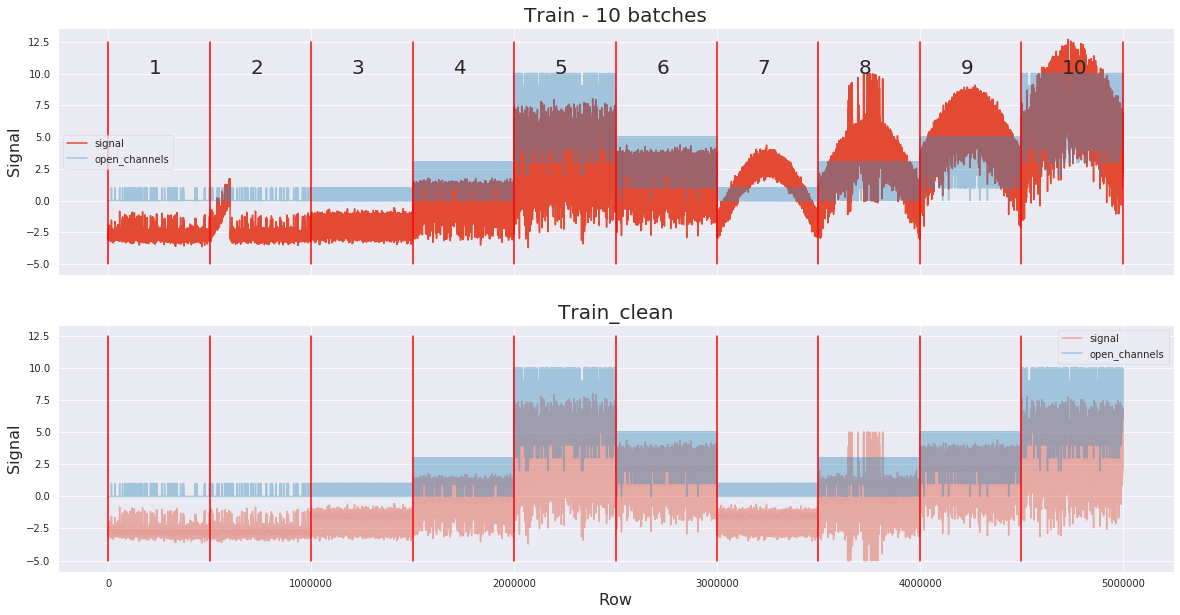

In [5]:
def plots(train, train_clean, batches, title0='signal', title1='signal_clean'):
    legs = ['signal','open_channels','signal_diff','signal-open_chn']
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True); res = 100

    axs[0].plot(range(0,train.shape[0],res), train.signal[0::res],marker='o',ms=0.01,label=legs[0])
    axs[0].plot(range(0,train.shape[0],res), train.open_channels[0::res],alpha=0.4,label=legs[1])

    for i in range(batches+1): 
        axs[0].plot([i*500000,i*500000],[-5,12.5],'r')
    for j in range(batches): 
        axs[0].text(j*500000+200000,10,str(j+1),size=20)

    axs[1].plot(range(0,train_clean.shape[0],res), train_clean.signal[0::res],marker='o',ms=0.01,label=legs[0],alpha=0.4)
    axs[1].plot(range(0,train_clean.shape[0],res), train_clean.open_channels[0::res],alpha=0.4,label=legs[1])

    for i in range(batches): 
        axs[1].plot([i*500000,i*500000],[-5,12.5],'r')

    axs[0].set_ylabel('Signal',size=16); axs[1].set_ylabel('Signal',size=16); axs[1].set_xlabel('Row',size=16);
    axs[0].set_title(title0,size=20); axs[1].set_title(title1,size=20)
    axs[0].legend(); axs[1].legend()
    plt.show()
    
plots(train, train_clean, batches=10, title0='Train - 10 batches', title1='Train_clean')

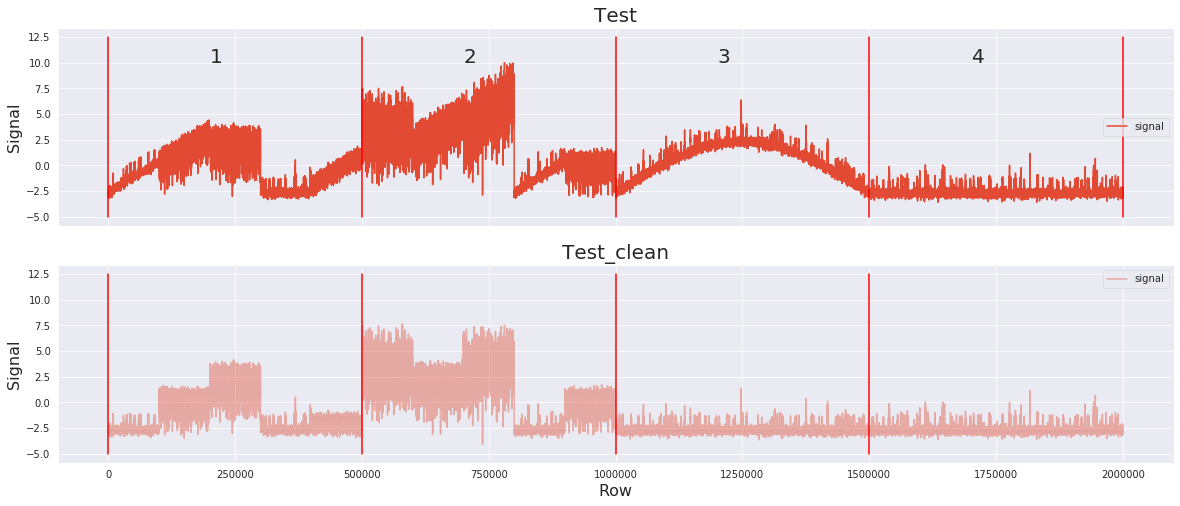

In [6]:
def plots1(test, test_clean, batches, res=100, title0='Test', title1='Test_clean'):
    legs = ['signal','open_channels','signal_diff','signal-open_chn']
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(20,8),sharex=True)

    axs[0].plot(range(0,test.shape[0],res), test.signal[0::res],marker='o',ms=0.01,label=legs[0])
    for i in range(batches+1): 
        axs[0].plot([i*500000,i*500000],[-5,12.5],'r')
    for j in range(batches): 
        axs[0].text(j*500000+200000,10,str(j+1),size=20)
        
    axs[1].plot(range(0,test_clean.shape[0],res), test_clean.signal[0::res], marker='o',ms=0.01,label=legs[0],alpha=0.4)

    for i in range(batches): 
        axs[1].plot([i*500000,i*500000],[-5,12.5],'r')

    axs[0].set_ylabel('Signal',size=16); axs[1].set_ylabel('Signal',size=16); axs[1].set_xlabel('Row',size=16);
    axs[0].set_title(title0,size=20); axs[1].set_title(title1,size=20)
    axs[0].legend(); axs[1].legend()
    plt.show()
plots1(test, test_clean, 4) 

In [7]:
def plot_5hist_signal(train, train_clean, batch_no):
    from scipy.stats import norm
    
    a = (batch_no-1)*500000; b = batch_no*500000; res=500
    print('#'*25)
    print('### Batch NO.%d'%batch_no)
    print('#'*25)
    
    fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(30,5))
    
    sns.distplot(train.signal[a:b],kde=False,ax=axs[0])
    sns.distplot(train_clean.signal[a:b],kde=False,ax=axs[1])
    
    chn_mu_sig = pd.DataFrame(columns=['chn', 'mu', 'sigma'])
    for i in range(11):
        if train_clean.signal[a:b][train.open_channels[a:b]==i].shape[0]>1000:
            #print(i)
            (mu, sigma) = norm.fit(train_clean.signal[a:b][train.open_channels[a:b]==i])
            sns.distplot(train_clean.signal[a:b][train.open_channels[a:b]==i],kde=False,ax=axs[2],
                         label=str(i)+', {0:.4g}, {1:.4f}'.format(mu, sigma))
            chn_mu_sig = chn_mu_sig.append({'chn': i, 'mu': mu,'sigma': sigma}, ignore_index=True)
    sns.regplot(x='chn',y='mu', data=chn_mu_sig, ax=axs[3]); 

    ab = np.polyfit(chn_mu_sig.chn, chn_mu_sig.mu, 1); axs[3].text(0.1,0.85,'slop:{0:.4f}, intercept:{1:.4f}'.format(ab[0],ab[1]),size=15,transform=axs[3].transAxes)

    # Get the fitted parameters used by sns
    sns.distplot((train_clean.signal[a:b]- ab[0]*train_clean.open_channels[a:b]-ab[1]),fit=norm,kde=False,ax=axs[4])
    (mu, sigma) = norm.fit((train_clean.signal[a:b]- ab[0]*train_clean.open_channels[a:b]-ab[1]),loc=0, scale=0.25)

    axs[0].set_xlabel('signal')
    axs[1].set_xlabel('clean_signal')
    axs[2].set_xlabel('clean_signal_by_chn');
    axs[4].set_xlabel('signal_clean - (a*open_chn+b)')
    
    # Legend and labels 
    axs[4].legend(["normal dist. fit\n ($\mu=${0:.4g},$\sigma=${1:.4f})".format(mu, sigma)])
    axs[2].legend(title='chn,  $\mu$,  $\sigma$')
    
    plt.show()

#########################
### Batch NO.1
#########################


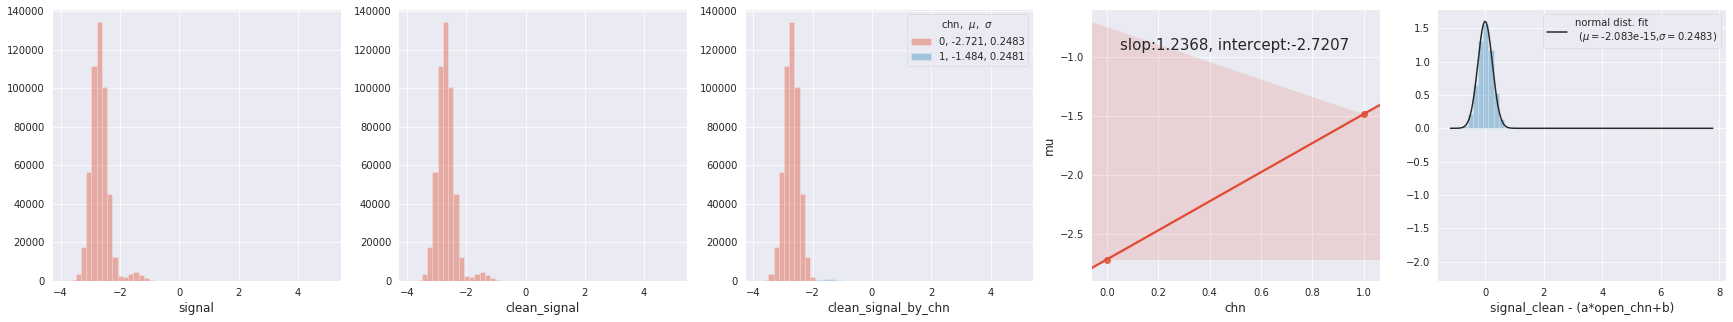

#########################
### Batch NO.2
#########################


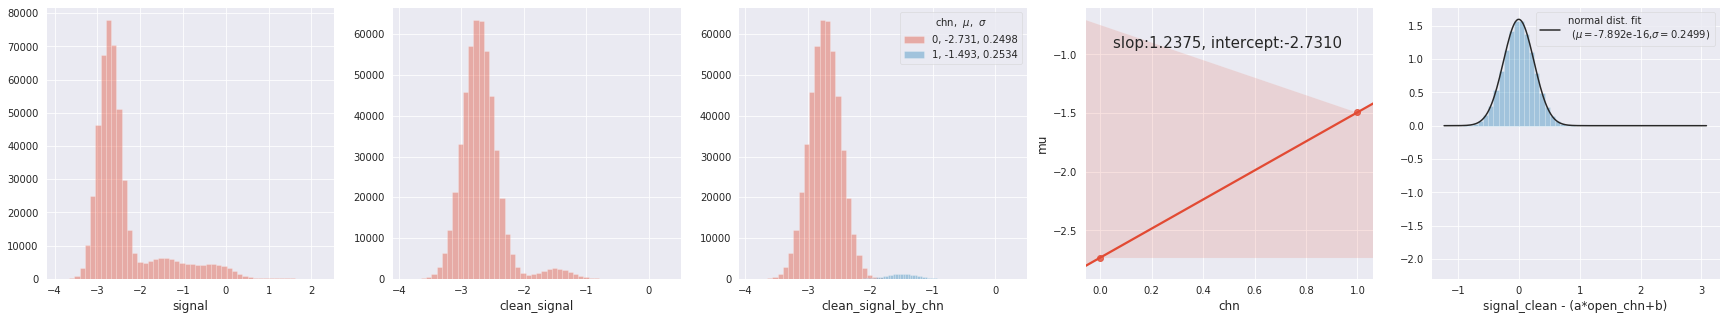

#########################
### Batch NO.3
#########################


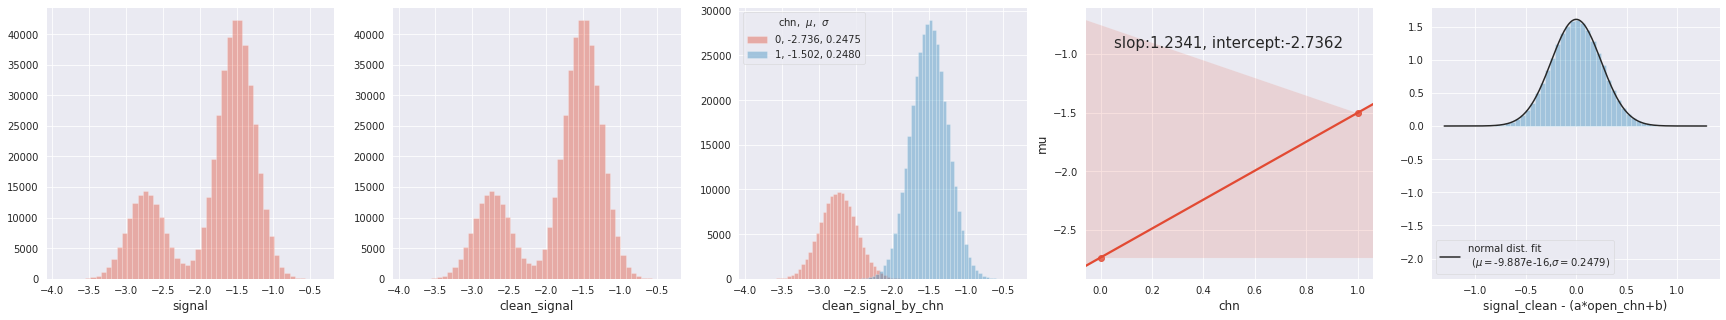

#########################
### Batch NO.7
#########################


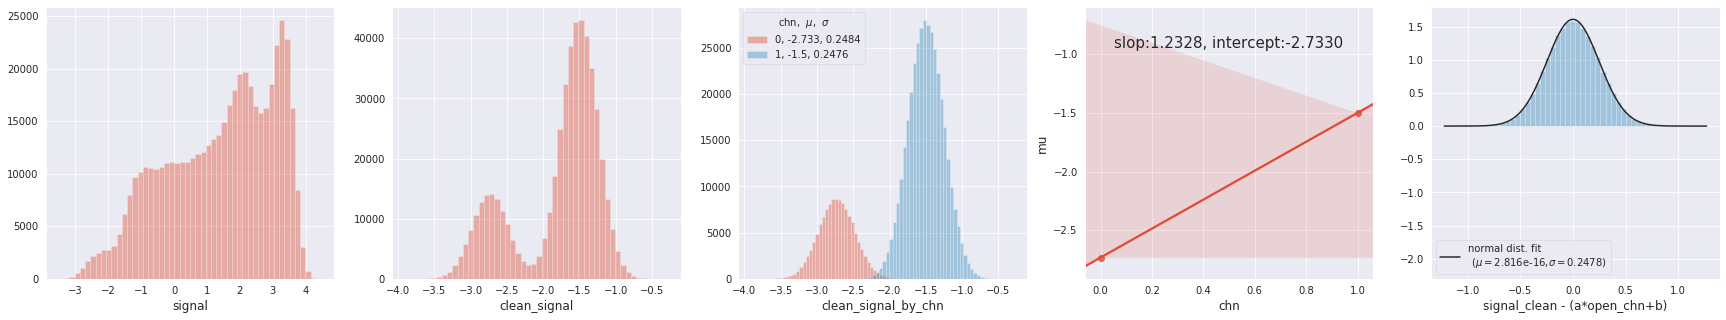

In [8]:
plot_5hist_signal(train, train_clean, 1)
plot_5hist_signal(train, train_clean, 2)
plot_5hist_signal(train, train_clean, 3)
plot_5hist_signal(train, train_clean, 7)

#########################
### Batch NO.4
#########################


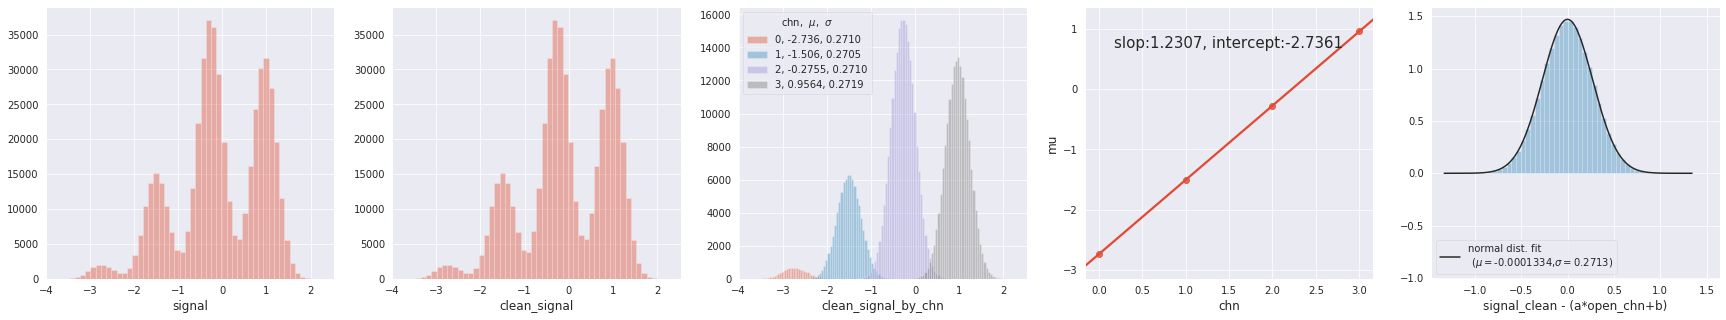

#########################
### Batch NO.8
#########################


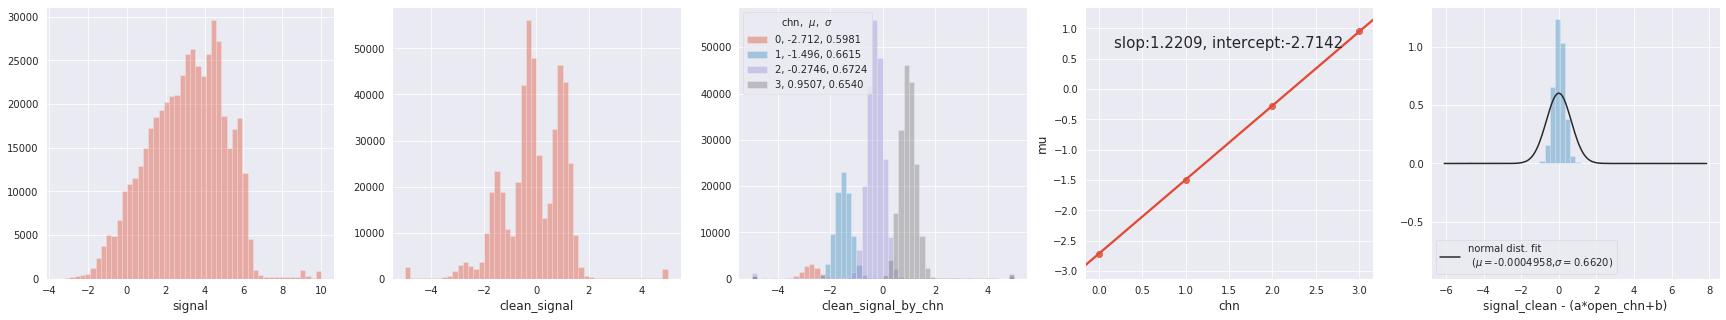

#########################
### Batch NO.6
#########################


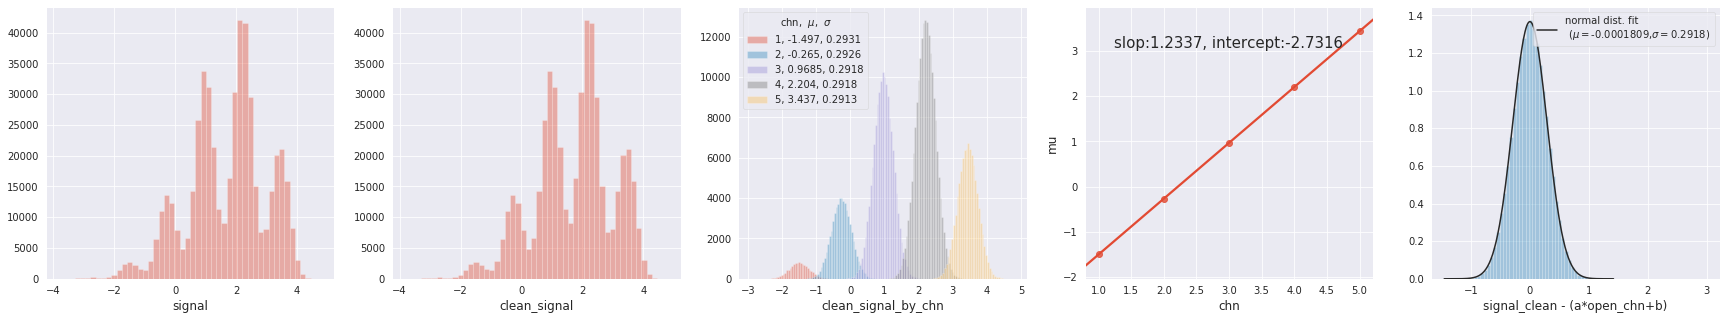

#########################
### Batch NO.9
#########################


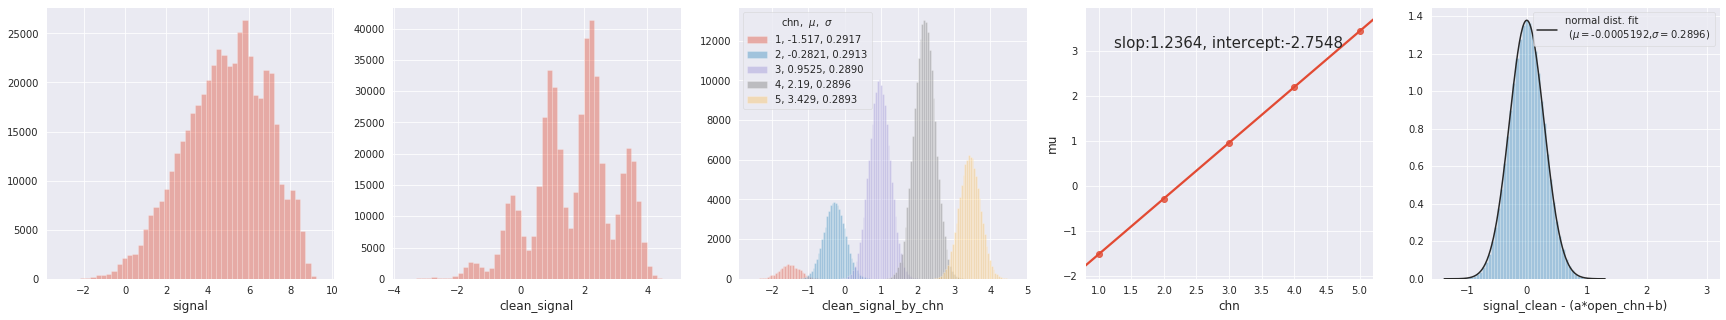

In [9]:
plot_5hist_signal(train, train_clean, 4)
plot_5hist_signal(train, train_clean, 8)
plot_5hist_signal(train, train_clean, 6)
plot_5hist_signal(train, train_clean, 9)

#########################
### Batch NO.5
#########################


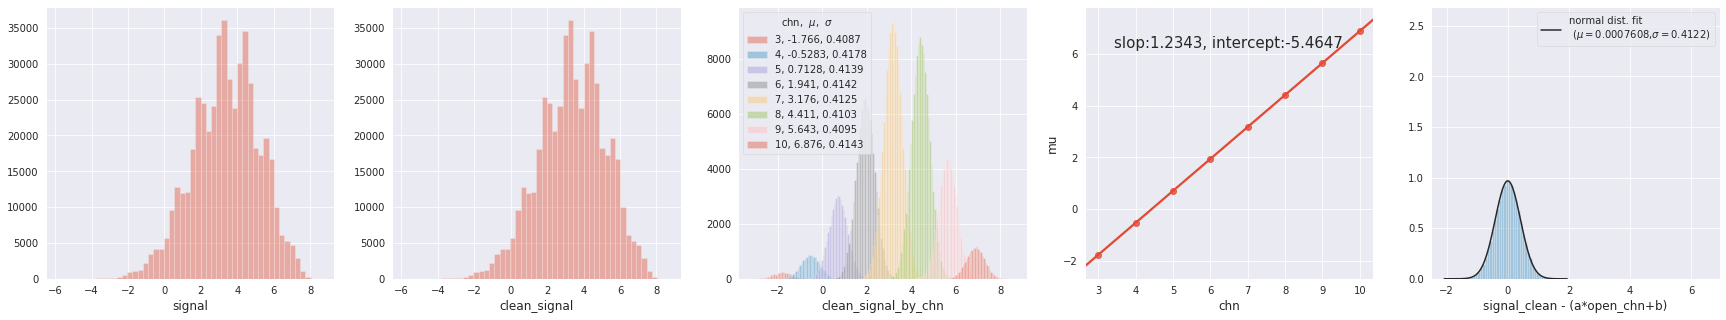

#########################
### Batch NO.10
#########################


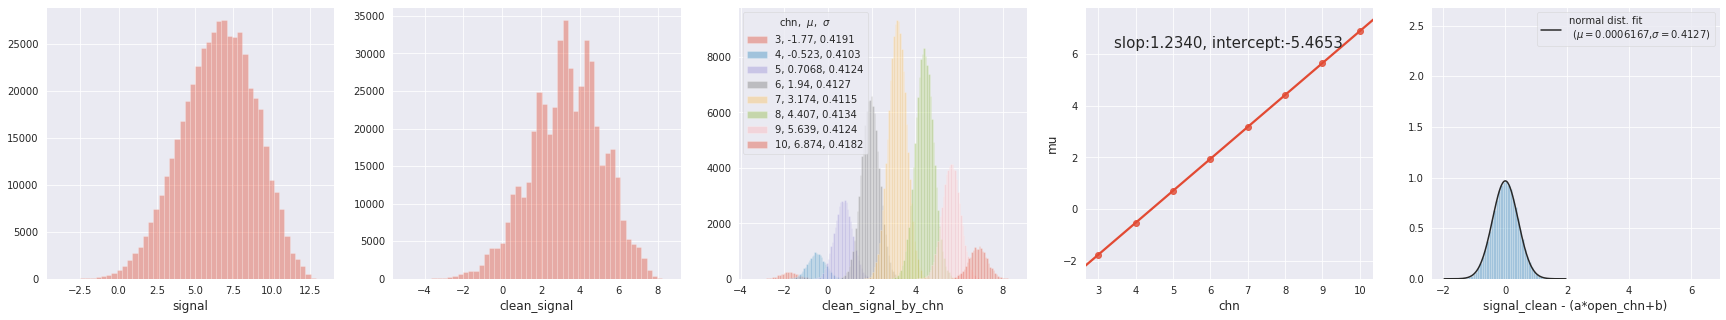

In [10]:
plot_5hist_signal(train, train_clean, 5)
plot_5hist_signal(train, train_clean, 10)

Reflections:
1. There is a linear relation between signal and open_channel, the slop is nearly the same for all batches, but the intercepts are different: -2.73, -5.46 (bactches 5 and 10)
2. The sigal has a normal distribution for different channels with increased wdith for batchs with more open_channels

### Distribution of of open_channels over time

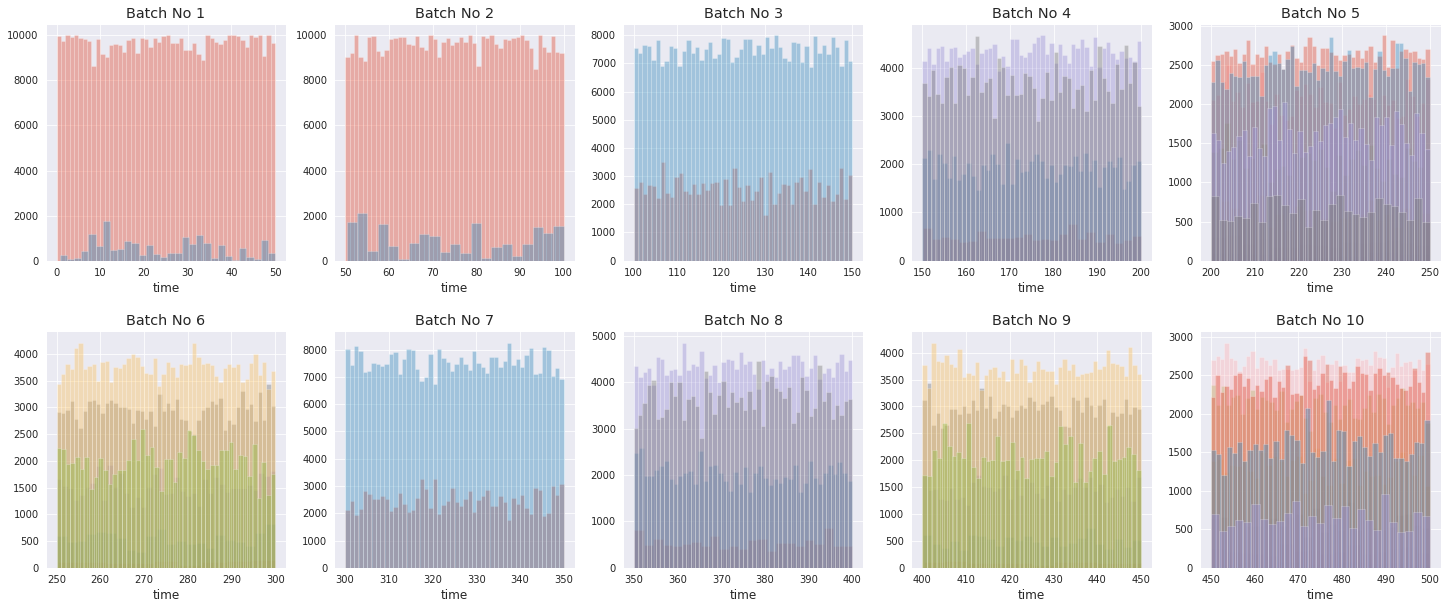

In [11]:
def plot_hist_time_channel(train): 
    fig, axs = plt.subplots(nrows=2,ncols=5,figsize=(25,10),gridspec_kw={'hspace':0.3})
    for i in range(10):
        a = i*500000; b = (i+1)*500000
        for j in range(11):
            if train.time[a:b][train.open_channels[a:b]==j].empty != True:
                sns.distplot(train.iloc[a:b].loc[train.iloc[a:b].open_channels==j, 'time'], kde=False, ax=axs[i//5,np.remainder(i,5)],label='open_chn {}'.format(j))
                axs[i//5,np.remainder(i,5)].set_title('Batch No {}'.format(i+1))
        if i==10: 
            axs[i//5,np.remainder(i,5)].legend()
    plt.show()
plot_hist_time_channel(train_clean)

# Compare (signal-b)/a, (signal_Kalman-b)/a with Open_channels

In [12]:
def compare_abSignal_chn(df, df_Kalman=None, batch=10,start=5000, end=5500, res=1):
    ab = [[1.23681698, -2.72065304],[1.23750154, -2.73096669],[1.23409502, -2.73621808],[1.23065603, -2.73611005],[1.23429745, -5.46470623],
          [1.23436182, -2.73395716],[1.23282196, -2.73299525],[1.22087484, -2.71416059],[1.23557789, -2.75182785],[1.22429227, -5.39251544]]
    slop, intercept = ab[batch-1]
    fig = go.Figure(data=go.Line(x=df.loc[df.batch==batch, 'time'][start:end:res], y=(df.loc[df.batch==batch,'signal'][start:end:res]-intercept)/slop, name='(signal-b)/a'))
    fig.add_trace(go.Line(x=df.loc[df.batch==batch, 'time'][start:end:res], y=df.loc[df.batch==batch,'open_channels'][start:end:res],name='open_chn' ))
    fig.add_trace(go.Line(x=df.loc[df.batch==batch, 'time'][start:end:res], y=(df.loc[df.batch==batch,'signal'][start:end:res]-intercept)/slop - 
                          df.loc[df.batch==batch,'open_channels'][start:end:res],name='(signal-b)/a - open_chn' ))
    if df_Kalman is not None:
        fig.add_trace(go.Line(x=df_Kalman.loc[df.batch==batch, 'time'][start:end:res], y=(df_Kalman.loc[df_Kalman.batch==batch,'signal'][start:end:res]-intercept)/slop, name='(signal_Kalman-b)/a' ))
        fig.add_trace(go.Line(x=df_Kalman.loc[df.batch==batch, 'time'][start:end:res], 
                              y=df_Kalman.loc[df_Kalman.batch==batch,'signal'][start:end:res]-df.loc[df.batch==batch,'signal'][start:end:res], name='signal-signal_Kalman' ))
        fig.add_trace(go.Line(x=df.loc[df_Kalman.batch==batch, 'time'][start:end:res], y=(df_Kalman.loc[df_Kalman.batch==batch,'signal'][start:end:res]-intercept)/slop - 
                              df.loc[df.batch==batch,'open_channels'][start:end:res],name='(signal_Kalman-b)/a - open_chn' ))
    
    fig.show()
    return

In [13]:
compare_abSignal_chn(train_clean, train_clean_Kalman, batch=5)

NameError: name 'train_clean_Kalman' is not defined

# ACF of noise, channels, sginal

In [14]:
# Plot: acf(abSignal-open_channels), acf(open_channels), pacf(open_channels), acf(abSignal_Kalman-open_channels)
def plot_acf_noise(df, df_Kalman=None, batch=10, start=5000,end=10000, res=1, lags=500 ):
    ab = [[1.23681698, -2.72065304],[1.23750154, -2.73096669],[1.23409502, -2.73621808],[1.23065603, -2.73611005],[1.23429745, -5.46470623],
          [1.23436182, -2.73395716],[1.23282196, -2.73299525],[1.22087484, -2.71416059],[1.23557789, -2.75182785],[1.22429227, -5.39251544]]
    slop, intercept = ab[batch-1]
    batch_sampled_diff = (df.loc[df.batch==batch,'signal'][start:end:res]-intercept)/slop - df.loc[df.batch==batch,'open_channels'][start:end:res]
    if df_Kalman is not None:
        fig, axs = plt.subplots(2,2,figsize=(16,8))
        axs = axs.flatten()
    else:
        fig, axs = plt.subplots(1,3,figsize=(25,3))
    
    plot_acf(batch_sampled_diff, lags=lags, title='acf_noise', ax=axs[0])
    plot_acf(df.loc[df.batch==batch,'open_channels'][start:end:res], lags=lags, title='acf_open_channels', ax=axs[1])
    plot_pacf(df.loc[df.batch==batch,'open_channels'][start:end:res], lags=lags, title='pacf_open_channels', ax=axs[2])
    
    if df_Kalman is not None:
        plot_acf((df_Kalman.loc[df.batch==batch,'signal'][start:end:res]-intercept)/slop - df_Kalman.loc[df.batch==batch,'open_channels'][start:end:res], 
                 lags=lags, title='acf_noise_Kalman', ax=axs[3])
    
plot_acf_noise(train_clean, train_clean_Kalman, start=0, end=20000, batch=5)

NameError: name 'train_clean_Kalman' is not defined

# FFT and spectrogram of the noise

Acknowledgements:

https://www.kaggle.com/kakoimasataka/remove-pick-up-electric-noise

https://www.kaggle.com/code1110/visualizing-added-noise-by-spectrogram

In [ ]:
def fft_noise(df, batch=10):
    ab = [[1.23681698, -2.72065304],[1.23750154, -2.73096669],[1.23409502, -2.73621808],[1.23065603, -2.73611005],[1.23429745, -5.46470623],
      [1.23436182, -2.73395716],[1.23282196, -2.73299525],[1.22087484, -2.71416059],[1.23557789, -2.75182785],[1.22429227, -5.39251544]]
    slop, intercept = ab[batch-1]
    
    noise = ((df.loc[df.batch==batch,'signal']-intercept)/slop - df.loc[df.batch==batch,'open_channels']) 

    F = fft.fft(noise)
    w = np.linspace(0, 1, len(F))
    plt.figure(figsize=(5,4))
    plt.plot(w, np.abs(F))
    plt.xlim(0, 0.01)
    plt.show()
fft_noise(train_clean, batch=5)

In [ ]:
def bandstop(x, samplerate = 1000000, fp = np.array([9850, 10150]), fs = np.array([9600, 10400])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / samplerate
    ws = fs / samplerate
    gpass = 1
    gstop = 10.0

    N, Wn = signal.buttord(wp, ws, gpass, gstop)
    b, a = signal.butter(N, Wn, "bandstop")
    y = signal.filtfilt(b, a, x)
    return y

def bandpass(x, samplerate = 1000000, fp = np.array([9850, 10150]), fs = np.array([9600, 10400])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / samplerate
    ws = fs / samplerate
    gpass = 1
    gstop = 10.0

    N, Wn = signal.buttord(wp, ws, gpass, gstop)
    b, a = signal.butter(N, Wn, "bandpass")
    y = signal.filtfilt(b, a, x)
    return y

def noise_spectrogram_plot(df, batch):
    # slop and intercept for the train dataset
    ab = [[1.23681698, -2.72065304],[1.23750154, -2.73096669],[1.23409502, -2.73621808],[1.23065603, -2.73611005],[1.23429745, -5.46470623],
          [1.23436182, -2.73395716],[1.23282196, -2.73299525],[1.22087484, -2.71416059],[1.23557789, -2.75182785],[1.22429227, -5.39251544]]
    slop, intercept = ab[batch-1]
    
    fig, ax = plt.subplots(5, 1, figsize=(8, 12), gridspec_kw={"height_ratios": [3,1, 1, 3,3]})
    ax = ax.flatten()
    
    # noise spectrogram
    fs = 10_000 # sampling rate is 10kHz of the signal: 0.0001sec step
    noise = (df.loc[df.batch==batch,'signal']-intercept)/slop - df.loc[df.batch==batch,'open_channels']
    f, t, Sxx = signal.spectrogram(noise , fs, nperseg=5000)
    ax[0].pcolormesh(t, f, -np.log(Sxx), cmap="plasma")
    ax[0].set_ylabel('Frequency [Hz]')
    ax[0].set_ylim([0, 500])
    ax[0].set_xlabel('Time [sec]')
    plt.tight_layout()
    
    # Power histogram (collapsed across time)
    ax[1].plot(f, np.log(np.mean(Sxx, axis=1)), color="g")
    ax[1].set_xlabel("Frequency [Hz]")
    ax[1].set_xlim([0, 500])
    ax[1].set_ylabel("Power")
    print('power max at ', f[np.argmax(np.mean(Sxx, axis=1))], 'Hz')
    
    # Power vs time for 50Hz
    ax[2].plot(t, Sxx[np.argmax(np.mean(Sxx, axis=1))], color="r")
    ax[2].set_xlabel('Time [sec]')
    ax[2].set_ylabel('Power for 50Hz')
    ax[2].set_xlim([0, 50])
    
    # Noise vs time and smoothed, filtered, removed
    start, end, res = 0, 5000, 1
    times = np.arange(start,end,res)*0.0001
    ax[3].plot(times,noise[start:end:res],label = "original",alpha=1)
    ax[3].plot(times,signal.savgol_filter(noise[start:end], 81, 3)[start:end:res],alpha=1,label='Smoothed',zorder=10)
    ax[3].set_xlabel('Time [sec]')
    ax[3].set_ylabel('Noise')
    ax[3].set_ylim([-1, 1])
    
    sig_pass = bandstop(noise)
    ax[3].plot(times, sig_pass[start:end:res], label = "Kept",alpha=1)
    sig_remove = bandpass(noise)
    ax[3].plot(times, sig_remove[start:end:res], label = "Removed",alpha=1)
    ax[3].legend()
    
    plot_acf(noise[0:20000], lags=500, label='acf_noise', ax=ax[4])
    plot_acf(sig_pass[0:20000], lags=500, label='acf_after', ax=ax[4])
    ax[4].set_ylim([-0.06,0.06])
    ax[4].legend()

In [ ]:
noise_spectrogram_plot(train_clean, batch=5)

### The noise has frequencies: 

1. AC electricity frequency 50Hz, and one weak 350Hz
2. The power varies as a function of time
3. The 0.02 sec periodicity is quite clear to see in the noise

# y_pred = round((signal-b)*a) for the train data

Batch 1 Accuracy 0.993812 f1 score 0.9537123691285307
Batch 2 Accuracy 0.993388 f1 score 0.9586233937063766
Batch 3 Accuracy 0.993498 f1 score 0.9914134741398096
Batch 7 Accuracy 0.99375 f1 score 0.991618654955364
Batch 4 Accuracy 0.981582 f1 score 0.9740978681108041
Batch 8 Accuracy 0.947316 f1 score 0.9047569863430118
Batch 6 Accuracy 0.968746 f1 score 0.9520101562600466
Batch 9 Accuracy 0.970496 f1 score 0.951498664762992
Batch 5 Accuracy 0.867566 f1 score 0.7790989109087415
Batch 10 Accuracy 0.864946 f1 score 0.7437033219550023
Final f1 score for the trainning data 0.9213605262572936


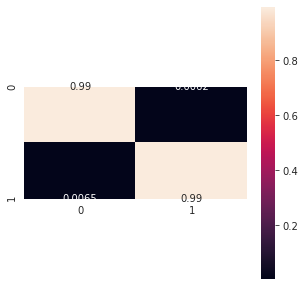

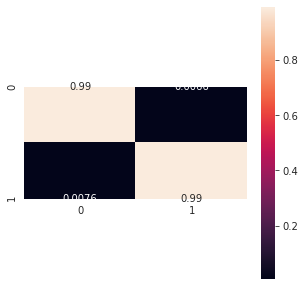

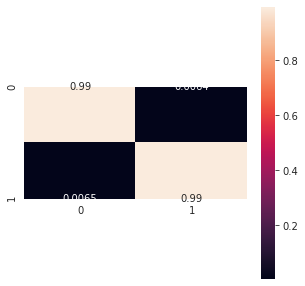

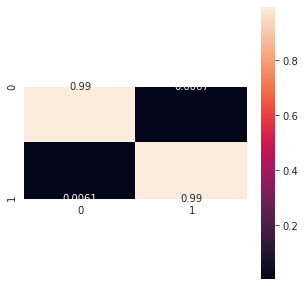

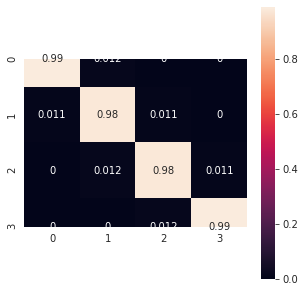

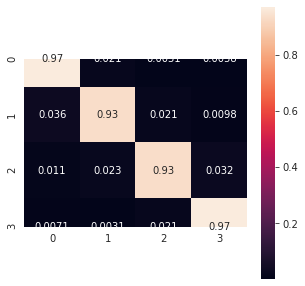

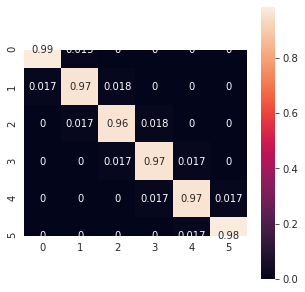

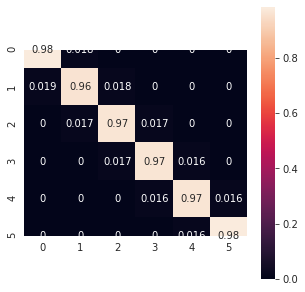

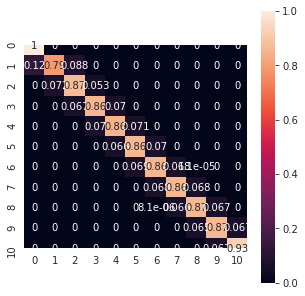

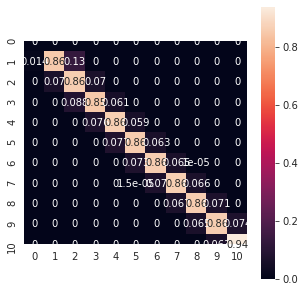

In [18]:
ab = [[1.23681698, -2.72065304],[1.23750154, -2.73096669],[1.23409502, -2.73621808],[1.23065603, -2.73611005],[1.23429745, -5.46470623],
      [1.23436182, -2.73395716],[1.23282196, -2.73299525],[1.22087484, -2.71416059],[1.23557789, -2.75182785],[1.22429227, -5.39251544]]

ul = [2,2,2,4,11,6,2,4,6,11] # upper limits

train_clean['open_channels_pred'] = np.nan

f1_s = []

for i in [1,2,3,7,
          4,8,
          6,9,
          5,10]:
    y_true = train_clean.loc[train.batch==i, 'open_channels']
    y_pred_raw = ( (train_clean.loc[train_clean.batch==i,'signal']-ab[i-1][1]) / ab[i-1][0] )
    y_pred = y_pred_raw.round().astype('int')
    y_pred[y_pred<=-1] = 0
    y_pred[y_pred>=ul[i-1]] = ul[i-1]-1
    
    train_clean.loc[train_clean.batch==i,'open_channels_pred_raw'] = y_pred_raw
    train_clean.loc[train_clean.batch==i,'open_channels_pred'] = y_pred
    
    f1 = f1_score(y_true, y_pred, average='macro')
    print('Batch %1d'%i,'Accuracy', np.sum(y_true==y_pred)/500000,'f1 score', f1)
    
    f1_s.extend([f1])
    
    cm = confusion_matrix(y_true,y_pred,normalize='true')
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set_aspect('equal')
    
print('Final f1 score for the trainning data',f1_score(train_clean['open_channels'],train_clean['open_channels_pred'],average='macro'))

## Optimize the rounder
https://www.kaggle.com/teejmahal20/physically-possible-optimized-rounder

shows bias to the dominante classes

In [15]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [17]:
train_clean

,time,signal,open_channels,batch
0,0.0001,-2.760000,0,1
1,0.0002,-2.855700,0,1
2,0.0003,-2.407400,0,1
3,0.0004,-3.140400,0,1
4,0.0005,-3.152500,0,1
...,...,...,...,...
4999995,499.9996,2.919274,7,10
4999996,499.9997,2.697906,7,10
4999997,499.9998,4.516337,8,10
4999998,499.9999,5.639669,9,10


In [19]:
# a few minuts to run
optR = OptimizedRounder()
optR.fit(train_clean['open_channels_pred_raw'], train_clean['open_channels'])
coefficients = optR.coefficients()
print(coefficients)

[0.51212532 1.50032642 2.4871661  3.52322653 4.50398297 5.48093967
 6.46969698 7.49861935 8.56475029 9.64503889]


In [22]:
def optimize_prediction(prediction):
    prediction[prediction <= coefficients[0]] = 0
    prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
    prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
    prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
    prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
    prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
    prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
    prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
    prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
    prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
    prediction[prediction > coefficients[9]] = 10
    
    return prediction

In [23]:
y_pred = optimize_prediction(train_clean['open_channels_pred_raw'].values)
f1_score(train_clean['open_channels'], y_pred, average = 'macro')

0.9223077408493038

In [ ]:
cm = confusion_matrix(train_clean['open_channels'],y_pred,normalize='true')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax)
ax.set_aspect('equal')

In [26]:
y_pred[2000000:2500000]

array([10., 10., 10., ...,  6.,  7.,  7.])

In [27]:
# np.save('../hmm/batch_5_pred.npy', y_pred[2000000:2500000])